Import Modules

In [6]:
#import required libraries
import geopandas as gpd
import rasterio
from rasterio import plot
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal, ogr
import json
import os
from os import listdir
from os.path import isfile, isdir, join
import math
from pprint import pprint
import shutil
import sys
import zipfile
import requests
import io
import webbrowser
import ee
%matplotlib inline

In [9]:
# https://stackoverflow.com/questions/51390968/python-ssl-certificate-verify-error
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context


Helper functions

In [18]:
# Functions modified from climada.util.earth_engine module
def obtain_image_landsat_composite(collection, time_range, area):
    """ Selection of Landsat cloud-free composites in the Earth Engine library
    See also: https://developers.google.com/earth-engine/landsat

    Parameters:
        collection (): name of the collection
        time_range (['YYYY-MT-DY','YYYY-MT-DY']): must be inside the available data
        area (ee.geometry.Geometry): area of interest

    Returns:
        image_composite (ee.image.Image)
     """
    collection = ee.ImageCollection(collection)

    ## Filter by time range and location
    collection_time = collection.filterDate(time_range[0], time_range[1])
    image_area = collection_time.filterBounds(area)
    image_composite = ee.Algorithms.Landsat.simpleComposite(image_area, 75, 3)
    return image_composite

def obtain_image_median(collection, time_range, area):
    """ Selection of median from a collection of images in the Earth Engine library
    See also: https://developers.google.com/earth-engine/reducers_image_collection

    Parameters:
        collection (): name of the collection
        time_range (['YYYY-MT-DY','YYYY-MT-DY']): must be inside the available data
        area (ee.geometry.Geometry): area of interest

    Returns:
        image_median (ee.image.Image)
     """
    collection = ee.ImageCollection(collection)

    ## Filter by time range and location
    collection_time = collection.filterDate(time_range[0], time_range[1])
    image_area = collection_time.filterBounds(area)
    image_median = image_area.median()
    return image_median

'''
The function below has been modified to accept the cloud cover threshold as an input
'''
def obtain_image_sentinel(collection, time_range, area, clouds):
    """ Selection of median, cloud-free image from a collection of images in the Sentinel 2 dataset
    See also: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

    Parameters:
        collection (): name of the collection
        time_range (['YYYY-MT-DY','YYYY-MT-DY']): must be inside the available data
        area (ee.geometry.Geometry): area of interest

    Returns:
        sentinel_median (ee.image.Image)
     """
#First, method to remove cloud from the image
    def maskclouds(image):
        band_qa = image.select('QA60')
        cloud_mask = ee.Number(2).pow(10).int()
        cirrus_mask = ee.Number(2).pow(11).int()
        mask = band_qa.bitwiseAnd(cloud_mask).eq(0) and(
            band_qa.bitwiseAnd(cirrus_mask).eq(0))
        return image.updateMask(mask).divide(10000)

    sentinel_filtered = (ee.ImageCollection(collection).
                         filterBounds(area).
                         filterDate(time_range[0], time_range[1]).
                         filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', clouds)).
                         map(maskclouds))

    sentinel_median = sentinel_filtered.median()
    return sentinel_median

def get_region(geom):
    """Get the region of a given geometry, needed for exporting tasks.

    Parameters:
        geom (ee.Geometry, ee.Feature, ee.Image): region of interest

    Returns:
        region (list)
    """
    if isinstance(geom, ee.Geometry):
        region = geom.getInfo()["coordinates"]
    elif isinstance(geom, ee.Feature, ee.Image):
        region = geom.geometry().getInfo()["coordinates"]
    elif isinstance(geom, list):
        condition = all([isinstance(item) == list for item in geom])
        if condition:
            region = geom
    return region

def get_url(name, image, scale, region, filePerBand=False):
    """It will open and download automatically a zip folder containing Geotiff data of 'image'.
    Parameters:
        name -  a base name to use when constructing filenames.
        image (ee.image.Image): image to export
        scale (int): resolution of export in meters (e.g: 30 for Landsat)
        region (list): region of interest
        filePerBand - whether to produce a different GeoTIFF per band (boolean).
            Defaults to true. If false, a single GeoTIFF is produced and all
            band-level transformations will be ignored.

    Returns:
        path (str)


    If additional parameters are needed, see also:
    https://github.com/google/earthengine-api/blob/master/python/ee/image.py

    Args:
        params: An object containing visualization options with the following
          possible values:
        name -  a base name to use when constructing filenames.
        bands -  a description of the bands to download. Must be an array of
            dictionaries, each with the following keys:
          id -  the name of the band, a string, required.
          crs -  an optional CRS string defining the band projection.
          crs_transform -  an optional array of 6 numbers specifying an affine
              transform from the specified CRS, in the order: xScale, yShearing,
              xShearing, yScale, xTranslation and yTranslation.
          dimensions -  an optional array of two integers defining the width and
              height to which the band is cropped.
          scale -  an optional number, specifying the scale in meters of the
                 band; ignored if crs and crs_transform is specified.
        crs -  a default CRS string to use for any bands that do not explicitly
            specify one.
        crs_transform -  a default affine transform to use for any bands that do
            not specify one, of the same format as the crs_transform of bands.
        dimensions -  default image cropping dimensions to use for any bands
            that do not specify them.
        scale -  a default scale to use for any bands that do not specify one;
            ignored if crs and crs_transform is specified.
        region -  a polygon specifying a region to download; ignored if crs
            and crs_transform is specified.
        filePerBand - whether to produce a different GeoTIFF per band (boolean).
            Defaults to true. If false, a single GeoTIFF is produced and all
            band-level transformations will be ignored.
     """
    path = image.getDownloadURL({
        'name':(name),
        'scale': scale,
        'region':(region),
        'filePerBand': (filePerBand)
        })

    webbrowser.open_new_tab(path)
    return path


Read Data 

In [23]:
# EDIT THE SEARCH OPTIONS BELOW

# YOU CAN PLACE A DIFFERENT SHAPEFILE ONTO YOUR GOOGLE DRIVE BUT MAKE SURE THAT
#    THE VARIABLE shapefile POINTS TO THE CORRECT FILE:
shapefile = '/Users/ajit/Desktop/Thames-Basin-floodAnalysis/thames_shapefile/POLYGON.shp' # ESRI Shapefile of the study area

# Define a date range for our search
datefrom = '2019-03-01' # start date for imagery search
dateto   = '2019-04-30' # end date for imagery searchA
time_range = [datefrom, dateto] # format as a list

# Define which cloud cover we accept in the images
clouds = 10 # maximum acceptable cloud cover in %

In [10]:
# Connect to Google Earth Engine API
# This will open a web page where you have to enter your account information and a code is provided. Paste it in the terminal.
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [24]:
driver = ogr.GetDriverByName("Esri Shapefile")
ds = driver.Open(shapefile, 0)
lyr = ds.GetLayer()
extent = lyr.GetExtent()
print("Extent of the area of interest (shapefile):\n", extent)
print(type(extent))

Extent of the area of interest (shapefile):
 (0.16026999212931514, 0.5408659145278705, 51.40264727649185, 51.54015966420425)
<class 'tuple'>


In [25]:
outSpatialRef = lyr.GetSpatialRef().ExportToWkt()
ds = None
print("\nSpatial referencing information of the shapefile:\n", outSpatialRef)


Spatial referencing information of the shapefile:
 GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [26]:
# GEE needs a special format for defining an area of interest. 
# It has to be a GeoJSON Polygon and the coordinates should be first defined in a list and then converted using ee.Geometry. 

extent_list = list(extent)
print(extent_list)
print(type(extent_list))

[0.16026999212931514, 0.5408659145278705, 51.40264727649185, 51.54015966420425]
<class 'list'>


In [27]:
area_list = list([(extent[0], extent[2]),
                  (extent[1], extent[2]),
                  (extent[1], extent[3]),
                  (extent[0], extent[3]),
                  (extent[0], extent[2])])
print(area_list)
print(type(area_list))

[(0.16026999212931514, 51.40264727649185), (0.5408659145278705, 51.40264727649185), (0.5408659145278705, 51.54015966420425), (0.16026999212931514, 51.54015966420425), (0.16026999212931514, 51.40264727649185)]
<class 'list'>


In [28]:
search_area = ee.Geometry.Polygon(area_list)
print(search_area)
print(type(search_area))

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              0.16026999212931514,
              51.40264727649185
            ],
            [
              0.5408659145278705,
              51.40264727649185
            ],
            [
              0.5408659145278705,
              51.54015966420425
            ],
            [
              0.16026999212931514,
              51.54015966420425
            ],
            [
              0.16026999212931514,
              51.40264727649185
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})
<class 'ee.geometry.Geometry'>


In [29]:
s2collection = ('COPERNICUS/S2')
s2median = obtain_image_sentinel(s2collection, time_range, search_area, clouds)
bands = ['B2', 'B3', 'B4', 'B8']
print(bands)
# spatial resolution of the downloaded data
resolution = 20 # in units of metres

['B2', 'B3', 'B4', 'B8']


In [30]:
search_region = get_region(search_area)
s2url = get_url('s2',s2median.select(bands), resolution, search_region, filePerBand=False)
print(s2url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e4cf2c7d4081274d9bd9403658d80743-0314e0a65722355b02205b4ec81ccad6:getPixels


In [31]:
def tci(afile, ax= None, bands=[3,2,1], percentiles=[0,100], xlim= None, ylim= None):
    
  def scale_to_uint8(x, percentiles=[0,100]):
    x = np.float32(x)
    amin = np.percentile(x, percentiles[0])
    amax = np.percentile(x, percentiles[1])
    anewmin = 0.0
    anewmax = 255.0
    ascaled = (a - amin) * ((anewmax - anewmin) / (amax - amin)) + anewmin
    return (ascaled.astype(np.uint8))


  tmpfile = rasterio.open('tmp_rgb_imagefile_ cjdlsbYFEOGFHEWBVUW.tiff',
                            'w',driver='Gtiff', width=afile.width, height=afile.height,
                            count=3, crs=afile.crs, transform=afile.transform, 
                            dtype=np.uint8)
  for b in range(3):
    a = afile.read(bands[b])
    a_uint8 = scale_to_uint8(a, percentiles)
    tmpfile.write(a_uint8, b+1)
  tmpfile.close()

  imgfile = rasterio.open(r'tmp_rgb_imagefile_ cjdlsbYFEOGFHEWBVUW.tiff', count=3)

  if (xlim == None):
    xlim = [afile.bounds.left, afile.bounds.right]

  if (ylim==None):
    ylim=[afile.bounds.bottom, afile.bounds.top]

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  plot.show(imgfile, ax=ax)

  imgfile.close()
  os.remove('tmp_rgb_imagefile_ cjdlsbYFEOGFHEWBVUW.tiff')
  return()


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


()

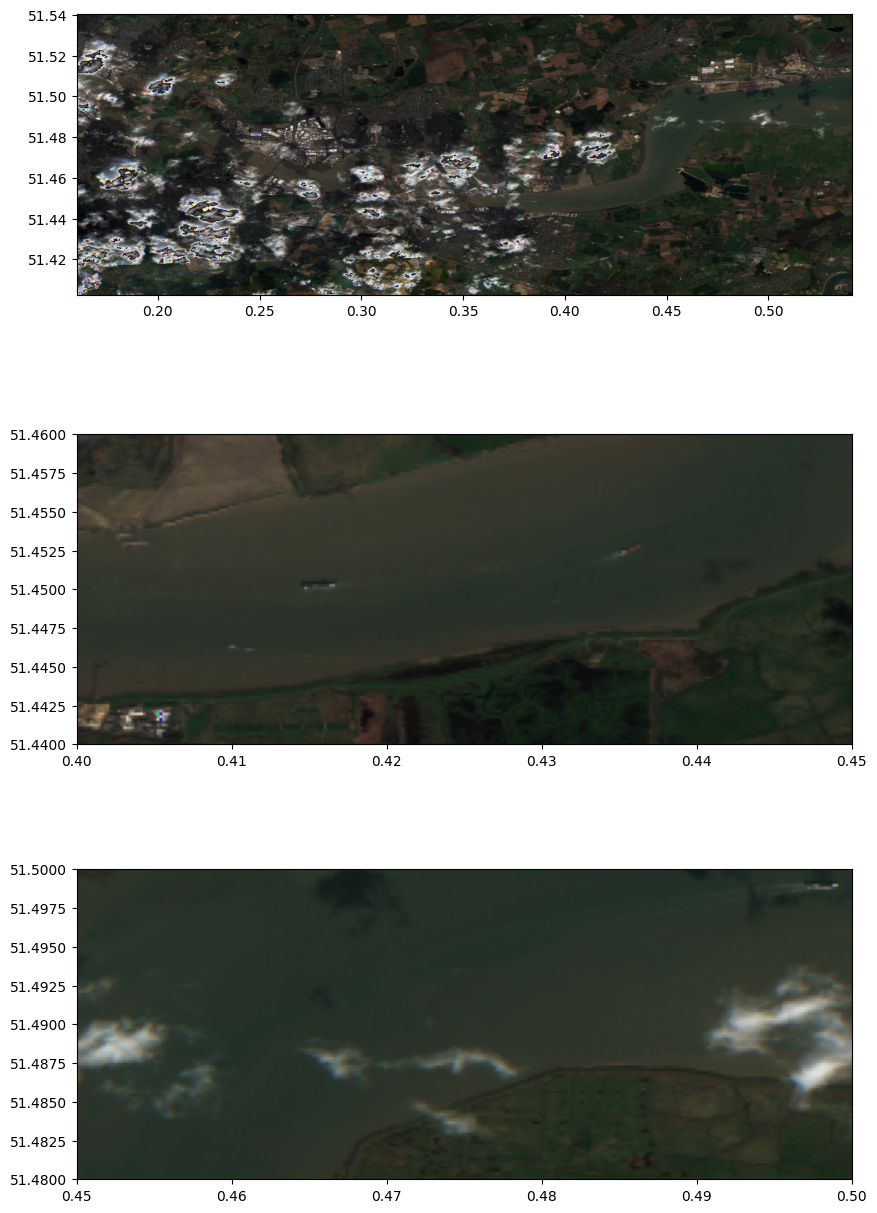

In [34]:
f = rasterio.open('s2.tif', 'r')

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,16))
fig.patch.set_facecolor('white')

# plot the image with full extent
tci(f, ax=ax1, percentiles=[0,98])

# zoom in to an area of interest
xlim=[0.40, 0.45] # longitude coordinates
ylim=[51.44, 51.46] # latitude coordinates
tci(f, ax=ax2, percentiles=[0,98], xlim=xlim, ylim=ylim)

# zoom in elsewhere
xlim=[0.45, 0.50]
ylim=[51.48, 51.50]
tci(f, ax=ax3, percentiles=[0,98], xlim=xlim, ylim=ylim)

To analyse several images, we can simply repeat the API query and download temporal composites. These are made automatically by Google Earth Engine. In our case, we want to calculate the median reflectance of all pixel values that are cloud-free, aggregated by month.
For this task, we copy and paste the code from above into a single cell (below), and iterate over the different months for our searches. The for loop does the job for us.
We will use the imageio library to make a movie from the results. And then download the file movie.gif from Colab using the folder icon on the left hand side. Locate the file in the 'out' directory, right-click and select 'download'.
Save it to your local hard drive and open it with Google Chrome to view it.

In [36]:
# make a list of lists with all date ranges for our new searches
months = [['2020-01-01', '2020-01-31'],
          ['2020-02-01', '2020-02-29'],
          ['2020-03-01', '2020-03-31'],
          ['2020-04-01', '2020-04-30'],
          ['2020-05-01', '2020-05-31'],
          ['2020-06-01', '2020-06-30'],
          ['2020-07-01', '2020-07-31'],
          ['2020-08-01', '2020-08-31'],
          ['2020-09-01', '2020-09-30'],
          ['2020-10-01', '2020-10-31']]

clouds = 30
bands = ['B2', 'B3', 'B4', 'B8']
resolution = 20

In [37]:
for i in range(len(months)):
  time_range = months[i]
  print(time_range)

  s2median = obtain_image_sentinel(s2collection, time_range, search_area, clouds)
  print(type(s2median))

  band_names = s2median.bandNames().getInfo()
  print(band_names)

  if len(band_names) == 0:
    print("Search returned no results.")
  else:
    file_id = 's2_month'
    s2url = get_url(file_id+"{0:3d}".format(i+1), s2median.select(bands), resolution, search_region, filePerBand=False)
    print(s2url)

    f = requests.get(s2url, stream = True)
    check = zipfile.is_zipfile(io.BytesIO(f.content))

    while not check:
        f = requests.get(s2url, stream =True)
        check = zipfile.is_zipfile(io.BytesIO(f.content))
    else:
        z = zipfile.ZipFile(io.BytesIO(f.content))
        z.extractall()

['2020-01-01', '2020-01-31']
<class 'ee.image.Image'>
['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60']
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/62a10681b5c7d033166e366e98c76258-8decb27d8c84f52edcb59a852a094b77:getPixels
['2020-02-01', '2020-02-29']
<class 'ee.image.Image'>
['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60']
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/255c94b596fafee25a4b6beae2e441ed-238fcac6010e3a3d5f671d529221caa1:getPixels
['2020-03-01', '2020-03-31']
<class 'ee.image.Image'>
['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60']
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a032c2077b9ad59de63dadf4457ed72-bd0610fe98e94449c13a7b7e4d325a08:getPixels
['2020-04-01', '2020-04-30']
<class 'ee.ima

KeyboardInterrupt: 

In [38]:
downloaddir = '/Users/ajit/Desktop/Thames-Basin-floodAnalysis'

In [39]:
allfiles = [i for i in listdir(downloaddir) if isfile(join(downloaddir, i))]
files_for_warp = [s for s in allfiles if file_id in s]
print("Files for warping:")
pprint(sorted(files_for_warp))

Files for warping:
['s2_month  1.tif',
 's2_month  2.tif',
 's2_month  3.tif',
 's2_month  4.tif',
 's2_month  5.tif']


In [40]:
for i in files_for_warp:
  warpfile = i.split('.')[0]+'_warped.tif'
  ds = gdal.Warp(warpfile, i, dstSRS=outSpatialRef)
  ds = None

Warning 1: s2_month  5.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: s2_month  4.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: s2_month  1.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't mat

In [41]:
# after downloading and warping all image composites, get a list of all warped tiff files in the directory
allfiles = [f for f in listdir(downloaddir) if isfile(join(downloaddir, f))]
warpfiles = [s for s in allfiles if "_warped.tif" in s]
print("Files after warping:")
pprint(sorted(warpfiles))

Files after warping:
['s2_month  1_warped.tif',
 's2_month  2_warped.tif',
 's2_month  3_warped.tif',
 's2_month  4_warped.tif',
 's2_month  5_warped.tif']


In [42]:
def save_as_uint8(afile,outfile, ax= None, bands=[3,2,1], percentiles=[0,100]):
    
  def scale_to_uint8(x, percentiles=[0,100]):
    x = np.float32(x)
    amin = np.percentile(x, percentiles[0])
    amax = np.percentile(x, percentiles[1])
    anewmin = 0.0
    anewmax = 255.0
    ascaled = (a - amin) * ((anewmax - anewmin) / (amax - amin)) + anewmin
    return (ascaled.astype(np.uint8))


  outf = rasterio.open(outfile,'w',driver='Gtiff', width=afile.width, height=afile.height,
                            count=3, crs=afile.crs, transform=afile.transform, 
                            dtype=np.uint8)
  for b in range(3):
    a = afile.read(bands[b])
    a_uint8 = scale_to_uint8(a, percentiles)
    outf.write(a_uint8, b+1)

  outf.close()
  return()

In [43]:
for i in sorted(warpfiles):
  print(i)
  wfile = rasterio.open(i, 'r')
  outfile = i.split(sep='.')[0] + '_uint8.tif'
  save_as_uint8(wfile, outfile)

s2_month  1_warped.tif
s2_month  2_warped.tif
s2_month  3_warped.tif
s2_month  4_warped.tif
s2_month  5_warped.tif


In [44]:
# get a list of all warped tiff files in uint8 data format in the directory
allfiles = [f for f in listdir(downloaddir) if isfile(join(downloaddir, f))]
uint8files = [s for s in allfiles if "_warped_uint8.tif" in s]
pprint(sorted(uint8files))

['s2_month  1_warped_uint8.tif',
 's2_month  2_warped_uint8.tif',
 's2_month  3_warped_uint8.tif',
 's2_month  4_warped_uint8.tif',
 's2_month  5_warped_uint8.tif']


In [45]:
import imageio
images = []
for i in sorted(uint8files):
  images.append(imageio.imread(i))
framerate = { 'duration': 3 }
imageio.mimsave(join(downloaddir, "movie.gif"), images, **framerate)

/var/folders/vq/21tb8yw15dl3k5cd0cp2f0nw0000gn/T/ipykernel_97179/207142419.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(i))
